In [1]:
import gc
import warnings

warnings.filterwarnings('ignore')
from importlib import reload
%load_ext autoreload

In [2]:
import dask
import xrft
import cmocean
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt

from dask.diagnostics import ProgressBar
from matplotlib.colors import LogNorm, TwoSlopeNorm

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39197")
client

<Client: 'tcp://127.0.0.1:39197' processes=4 threads=16, memory=15.07 GiB>

In [4]:
import logging
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.DEBUG,
    datefmt="%Y-%m-%d %H:%M:%S")

#logging.getLogger("matplotlib.font_manager").setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

In [5]:
#%reload_ext autoreload
%autoreload

#reload() solo funciona si el módulo ya fue cargado
import spectral_analysis
reload(spectral_analysis)
import spectral_analysis.filtering
reload(spectral_analysis.filtering)
from spectral_analysis.filtering import kxky, f_range
import spectral_analysis.tools.utils_thesis
reload(spectral_analysis.tools.utils_thesis)
from spectral_analysis.common_vars.directories import DATA_FOLDER
#from spectral_analysis.tools.utils_thesis import igw_disp_rel, igw_bm_partition_k

from spectral_analysis.common_vars.time_slices import idx_t
from spectral_analysis.luigi_workflows.llc_region import LLCRegion

In [6]:
from spectral_analysis.common_vars.directories import DATA_FOLDER

rid = 730 #730 #771
lat_deg = 21.611 #21.611 #31.462
Omega = 1.0/(24.0) # cph
RdC1_data = pd.read_csv('{}/merged_Rd_c1_H_Nbv.csv'.format(DATA_FOLDER),index_col='s_id')
f = 2*Omega*np.sin(lat_deg*np.pi/180.0)
spectrum_var = "KE"
season="ASO"

Omega_mks = 1/(24*3600) # cps
f_mks = 2*Omega_mks*np.sin(lat_deg*np.pi/180.0)

gc.collect()
client.run(gc.collect)

{'tcp://127.0.0.1:42563': 58,
 'tcp://127.0.0.1:44411': 58,
 'tcp://127.0.0.1:44619': 58,
 'tcp://127.0.0.1:44969': 58}

In [7]:
#@dask.delayed(pure=True, nout=2)
def kxky_(dx,dy,shape):
    Ny,Nx = shape
    logging.info("kxky -- Nx: {}, Ny: {}".format(Nx,Ny))
    Lx = Nx*dx
    Ly = Ny*dy
    logging.info("kxky -- Lx: {}, Ly: {}".format(Lx,Ly))
    delta_kx = 1/Lx
    delta_ky = 1/Ly
    N_kx = (Nx-1)/2
    N_ky = (Ny-1)/2
    Kx = delta_kx*da.arange(-N_kx,N_kx+1)
    Ky = delta_ky*da.arange(-N_ky,N_ky+1)
    return Kx,Ky

#@dask.delayed(pure=True)
def f_range_(dt,Nt):
    T = Nt*dt
    logging.info("f_range -- Nt: {}, T: {}".format(Nt,T))
    delta_om = 1/T
    N_om = (Nt-1)/2
    return  delta_om*da.arange(-N_om,N_om+1)

In [8]:
## Units:
## kh,H: km
## f,Nbv: cph

#@dask.delayed(pure=True)
def igw_disp_rel(kh, f_coriolis, nn, Nbv=0.8594, H=4, log=True):
    if log:
        print("N={0:.3f}, H={1:.3f} - mode {2}".format(Nbv,H,nn))
    kh = (2*np.pi)*kh 	# Transform to rad/km
    khnp_2 = (nn*np.pi/(kh*H))**2

    return da.sqrt( (Nbv**2 + ((f_coriolis**2)*khnp_2))/(1+khnp_2) )


#@dask.delayed(pure=True)
def igw10_bm_partition_k(kh, f_coriolis, fmax, Nbv=0.8594,H=4,log=True):
    igw10 = igw_disp_rel(kh, f_coriolis, 10, Nbv=Nbv, H=H, log=log)
    logging.debug("igw10 shape: {}".format(igw10.shape))

    return da.fmin(igw10, fmax)


#@dask.delayed(pure=True, nout=4)
def create_igw10_cutoff(shape, f_coriolis, dx=2.0, dy=2.0, dt=1.0, fmax=1.0/12.0):
    Nx,Ny,Nt = shape
    om_ = f_range_(dt,Nt)
    kx_,ky_ = kxky_(dx, dy, (Nx,Ny))
    kx,ky,om = da.meshgrid(kx_, ky_, om_)
    #logging.debug("spectral shape: {}, {}, {} --> {}, {}, {}", kx_.shape, ky_.shape, om_.shape, kx.shape, ky.shape, om.shape)

    kh_sq = da.square(kx)+da.square(ky)
    kh = da.sqrt(kh_sq)

    return igw10_bm_partition_k(kh, f_coriolis, fmax), kx, ky, om


#@dask.delayed(pure=True, nout=4)
def create_filter_igw10(shape, f_coriolis, order=50, **filter_kwargs):
    cutoff_igw10, kx, ky, om = create_igw10_cutoff(shape, f_coriolis, **filter_kwargs)
    logging.debug("cutoff_igw10 shape: {}".format(cutoff_igw10.shape))
    with np.errstate(over='ignore'):
        filter_mask_plt = 1/( 1 + ( da.square(om)/(cutoff_igw10**2) )**order )
        return filter_mask_plt, kx, ky, om


## Testing filter

In [80]:
shape = (200,250,300)
cutoff_igw10, kx, ky, kz = create_igw10_cutoff(shape, f)
id_data = RdC1_data.loc[rid]
Nbv = id_data["Nbv_cph_2"]
H = id_data["H"]/1000
print("f_coriolis", f, "N_bv", Nbv)
print("igw10 out shape:", cutoff_igw10.shape, np.min(cutoff_igw10), np.max(cutoff_igw10))

2022-01-31 20:05:29 INFO     f_range -- Nt: 300, T: 300.0
2022-01-31 20:05:29 INFO     kxky -- Nx: 250, Ny: 200
2022-01-31 20:05:29 INFO     kxky -- Lx: 500.0, Ly: 400.0
2022-01-31 20:05:29 DEBUG    igw10 shape: (200, 250, 300)


N=0.859, H=4.000 - mode 10
f_coriolis 0.04166666666666666 N_bv 1.0138111316459193
igw10 out shape: (200, 250, 300) dask.array<amin-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray> dask.array<amax-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


TypeError: Truth of Delayed objects is not supported

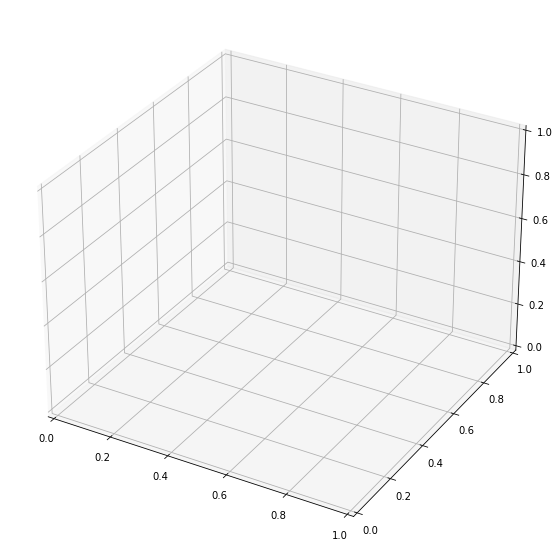

In [ ]:
zidx = 0 # All of them should yield the exact same plot
X,Y,Z = kx[:,:,zidx], ky[:,:,zidx], cutoff_igw10[:,:,zidx]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
cs = ax.plot_surface(X, Y, Z, cmap='cmo.ice_r', norm=LogNorm(vmin=f), linewidth=0, antialiased=False)
ax.contourf(X, Y, Z, zdir='z', offset=0, cmap='cmo.ice_r')
plt.colorbar(cs)
ax = plt.gca()
#ax.set_xscale('symlog')
#ax.set_yscale('symlog')
ax.set_zscale('symlog')
ax.set_zlim([0, None])
plt.show()

In [ ]:
filter_mask, kx, ky, om = create_filter_igw10(shape, f)

# In this case, since filter cutoff depends on k_h, and filter depends on frequency, each "sheet" varies with frequency (idx)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,15))
nlevels = 100
filter_levels = [x/nlevels for x in range(0, nlevels+1)];
print("T coriolis", 1/f)

for idx in range(155,175,2):
    X,Y,Z,C = kx[:,:,idx], ky[:,:,idx], om[:,:,idx], filter_mask[:,:,idx]
    print("period (hr)", 1/Z[0,0])
    print("range", np.min(C), np.max(C))
    cs = ax.contour(X, Y, C, filter_levels, offset=np.min(Z), cmap='cmo.ice_r', vmax=1,vmin=1e-3)
plt.colorbar(cs, ticks=filter_levels[::10])
ax = plt.gca()
#ax.set_xscale('symlog')
#ax.set_yscale('symlog')
ax.set_zlim([om[0,0,155], om[0,0,175]])
#ax.set_zscale('log')
plt.show()

## Real example

In [9]:
# TODO: multiplicar por Hanning

def fft_3d(var_txy, inverse=False):
    _v_fft = var_txy
    dim = len(var_txy.shape)
    for ax in range(dim):
        rechunks = {x:'auto' for x in range(dim) }
        rechunks[ax] = -1
        _v_fft = _v_fft.rechunk(rechunks)
        _v_fft = da.fft.fft(_v_fft, axis=ax) if not inverse else da.fft.ifft(_v_fft, axis=ax)
    return _v_fft

#@dask.delayed(pure=True)
def filter_fft_butterworth_k_omega(var_txy, f_coriolis, filter_mask, dx=2.0, dy=2.0, dt_h=1, t_axis=-1):
    logging.info("kx-ky-omega BW filter -- variable shape: {} -- type: {}".format(var_txy.shape, type(var_txy)))
    arr_delayed_kwargs = {"shape": var_txy.shape, "dtype": np.dtype('f')}
    filter_mask = da.fft.ifftshift(filter_mask)
    
    logging.info("Calculating FFT... mask type: {}".format(type(filter_mask)))
    #var_fft = xrft.fft(var_txy)
    var_fft = fft_3d(var_txy)
    logging.info("Filtering...")
    var_lo = filter_mask*var_fft
    del filter_mask
    
    # Volvemos al espacio físico
    logging.info("Calculating inverse FFT and complement")
    #var_lo = xrft.ifft(var_lo)
    var_lo = fft_3d(var_lo, inverse=True)
    logging.info("Taking real part FFT: {}".format(type(var_lo)))
    var_lo = da.real(var_lo)   # Eliminamos la parte imaginaria, ya que es espuria
    
    return var_lo


In [10]:
timevec = idx_t["hours"][season][35*24:-35*24]

region = LLCRegion(rid, timevec, tag="Winter", nWorkers=40)
grid = region.getGrid()
XG,YG = region.getGridG()
region.loadScalar("U")
region.loadScalar("V")
UU = region.get("U")
VV = region.get("V")

2022-02-17 11:09:30 INFO     Grid: dx = 2.1525167858620695 km, dy = 1.9787329799999998 km, dt = 1 h
2022-02-17 11:09:30 INFO     Exists? 730: _Winter -- Filename /data/LLC4320/Postprocess/wk_spectra/730_Winter_hours.npz
2022-02-17 11:09:30 INFO     Spectra - Variables: []
2022-02-17 11:09:30 INFO     Loading U: shape (k=0): (290, 289, 528)
2022-02-17 11:09:30 INFO     Loading V: shape (k=0): (290, 289, 528)


var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>
var4Id type <class 'list'>
var4Id type stacked <class 'dask.array.core.Array'>


In [74]:
#folder = LUIGI_OUT_FOLDER+"/Datasets_compressed/730/JFM/V"
#da.to_npy_stack(folder, region.get("V"), axis=2)

In [76]:
#UU = da.from_npy_stack(LUIGI_OUT_FOLDER+"/Datasets_compressed/730/JFM/U")
#VV = da.from_npy_stack(LUIGI_OUT_FOLDER+"/Datasets_compressed/730/JFM/V")

In [12]:
ds = xr.Dataset(
    {
        "U": (["i", "j", "t"], UU),
        "V": (["i", "j", "t"], VV),
    },
    coords={
        "lon": (["i", "j"], XG),
        "lat": (["i", "j"], YG),
        "time": (["t"], region.t),
    }
)

gc.collect()
client.run(gc.collect)

ds

<xarray.Dataset>
Dimensions:  (i: 290, j: 289, t: 528)
Coordinates:
    lon      (i, j) float64 -26.0 -25.98 -25.96 -25.94 ... -20.04 -20.02 -20.0
    lat      (i, j) float64 19.03 19.03 19.03 19.03 ... 24.18 24.18 24.18 24.18
    time     (t) int64 8592 8593 8594 8595 8596 ... 9115 9116 9117 9118 9119
Dimensions without coordinates: i, j, t
Data variables:
    U        (i, j, t) float32 dask.array<chunksize=(290, 289, 1), meta=np.ndarray>
    V        (i, j, t) float32 dask.array<chunksize=(290, 289, 1), meta=np.ndarray>

In [13]:
filter_mask, *_ = create_filter_igw10(UU.shape, f, fmax=1.0/25.0)

U_lo = filter_fft_butterworth_k_omega(UU, f, filter_mask)
V_lo = filter_fft_butterworth_k_omega(VV, f, filter_mask)
U_hi = UU-U_lo
V_hi = VV-V_lo

2022-02-17 11:28:55 INFO     f_range -- Nt: 528, T: 528.0
2022-02-17 11:28:55 INFO     kxky -- Nx: 289, Ny: 290
2022-02-17 11:28:55 INFO     kxky -- Lx: 578.0, Ly: 580.0
2022-02-17 11:28:55 DEBUG    igw10 shape: (290, 289, 528)
2022-02-17 11:28:55 DEBUG    cutoff_igw10 shape: (290, 289, 528)
2022-02-17 11:28:55 INFO     kx-ky-omega BW filter -- variable shape: (290, 289, 528) -- type: <class 'dask.array.core.Array'>
2022-02-17 11:28:55 INFO     Calculating FFT... mask type: <class 'dask.array.core.Array'>
2022-02-17 11:28:55 INFO     Filtering...
2022-02-17 11:28:55 INFO     Calculating inverse FFT and complement
2022-02-17 11:28:55 INFO     Taking real part FFT: <class 'dask.array.core.Array'>
2022-02-17 11:28:55 INFO     kx-ky-omega BW filter -- variable shape: (290, 289, 528) -- type: <class 'dask.array.core.Array'>
2022-02-17 11:28:55 INFO     Calculating FFT... mask type: <class 'dask.array.core.Array'>
2022-02-17 11:28:55 INFO     Filtering...
2022-02-17 11:28:55 INFO     Calcula

N=0.859, H=4.000 - mode 10


In [14]:
U_lo = U_lo.rechunk({0:'auto', 1:'auto', 2:30})
V_lo = V_lo.rechunk({0:'auto', 1:'auto', 2:30})
U_hi = U_hi.rechunk({0:'auto', 1:'auto', 2:30})
V_hi = V_hi.rechunk({0:'auto', 1:'auto', 2:30})

In [15]:
V_hi

dask.array<rechunk-merge, shape=(290, 289, 528), dtype=float64, chunksize=(290, 289, 30), chunktype=numpy.ndarray>

In [16]:
U_tmp = da.moveaxis(UU, -1, 0)
V_tmp = da.moveaxis(VV, -1, 0)
U_lo_tmp = da.moveaxis(U_lo, -1, 0)
V_lo_tmp = da.moveaxis(V_lo, -1, 0)
U_hi_tmp = da.moveaxis(U_hi, -1, 0)
V_hi_tmp = da.moveaxis(V_hi, -1, 0)

In [17]:
V_hi_tmp

dask.array<transpose, shape=(528, 290, 289), dtype=float64, chunksize=(30, 290, 289), chunktype=numpy.ndarray>

In [18]:
f_mks_inv = da.reciprocal(f_mks)

RV = grid.rv(U_tmp, V_tmp)*f_mks_inv
DIV = grid.div(U_tmp, V_tmp)*f_mks_inv
RV_lo = grid.rv(U_lo_tmp, V_lo_tmp)*f_mks_inv
DIV_lo = grid.div(U_lo_tmp, V_lo_tmp)*f_mks_inv
RV_hi = grid.rv(U_hi_tmp, V_hi_tmp)*f_mks_inv
DIV_hi = grid.div(U_hi_tmp, V_hi_tmp)*f_mks_inv

In [19]:
ds["U_low"] = (["i", "j", "t"], U_lo)
ds["V_low"] = (["i", "j", "t"], V_lo)
ds["U_high"] = (["i", "j", "t"], U_hi)
ds["V_high"] = (["i", "j", "t"], V_hi)
## RV, DIV
ds["RV"] = (["t", "i", "j"], RV)
ds["RVlo"] = (["t", "i", "j"], RV_lo)
ds["RVhi"] = (["t", "i", "j"], RV_hi)
ds["DIV"] = (["t", "i", "j"], DIV)
ds["DIVlo"] = (["t", "i", "j"], DIV_lo)
ds["DIVhi"] = (["t", "i", "j"], DIV_hi)
## Stats: AVG
ds["U_avg"] = ds.U.mean(["i", "j"])
ds["V_avg"] = ds.V.mean(["i", "j"])
ds["Ulo_avg"] = ds.U_low.mean(["i", "j"])
ds["Uhi_avg"] = ds.U_high.mean(["i", "j"])
ds["Vlo_avg"] = ds.V_low.mean(["i", "j"])
ds["Vhi_avg"] = ds.V_high.mean(["i", "j"])
ds["DIV_avg"] = ds.DIV.mean(["i", "j"])
ds["RV_avg"] = ds.RV.mean(["i", "j"])
ds["DIVlo_avg"] = ds.DIVlo.mean(["i", "j"])
ds["RVlo_avg"] = ds.RVlo.mean(["i", "j"])
ds["DIVhi_avg"] = ds.DIVhi.mean(["i", "j"])
ds["RVhi_avg"] = ds.RVhi.mean(["i", "j"])
## Stats: STD
ds["U_rms"] = ds.U.std(["i", "j"])
ds["V_rms"] = ds.V.std(["i", "j"])
ds["Ulo_rms"] = ds.U_low.std(["i", "j"])
ds["Uhi_rms"] = ds.U_high.std(["i", "j"])
ds["Vlo_rms"] = ds.V_low.std(["i", "j"])
ds["Vhi_rms"] = ds.V_high.std(["i", "j"])
ds["DIV_rms"] = ds.DIV.std(["i", "j"])
ds["RV_rms"] = ds.RV.std(["i", "j"])
ds["DIVlo_rms"] = ds.DIVlo.std(["i", "j"])
ds["RVlo_rms"] = ds.RVlo.std(["i", "j"])
ds["DIVhi_rms"] = ds.DIVhi.std(["i", "j"])
ds["RVhi_rms"] = ds.RVhi.std(["i", "j"])

del UU, VV, U_lo, V_lo, U_hi, V_hi, RV, DIV, RV_lo, DIV_lo, RV_hi, DIV_hi
gc.collect()
client.run(gc.collect)

ds

<xarray.Dataset>
Dimensions:    (i: 290, j: 289, t: 528)
Coordinates:
    lon        (i, j) float64 -26.0 -25.98 -25.96 -25.94 ... -20.04 -20.02 -20.0
    lat        (i, j) float64 19.03 19.03 19.03 19.03 ... 24.18 24.18 24.18
    time       (t) int64 8592 8593 8594 8595 8596 ... 9115 9116 9117 9118 9119
Dimensions without coordinates: i, j, t
Data variables: (12/36)
    U          (i, j, t) float32 dask.array<chunksize=(290, 289, 1), meta=np.ndarray>
    V          (i, j, t) float32 dask.array<chunksize=(290, 289, 1), meta=np.ndarray>
    U_low      (i, j, t) float64 dask.array<chunksize=(290, 289, 30), meta=np.ndarray>
    V_low      (i, j, t) float64 dask.array<chunksize=(290, 289, 30), meta=np.ndarray>
    U_high     (i, j, t) float64 dask.array<chunksize=(290, 289, 30), meta=np.ndarray>
    V_high     (i, j, t) float64 dask.array<chunksize=(290, 289, 30), meta=np.ndarray>
    ...         ...
    DIV_rms    (t) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    RV_rms     (t) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    DIVlo_rms  (t) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    RVlo_rms   (t) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    DIVhi_rms  (t) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    RVhi_rms   (t) float64 dask.array<chunksize=(30,), meta=np.ndarray>

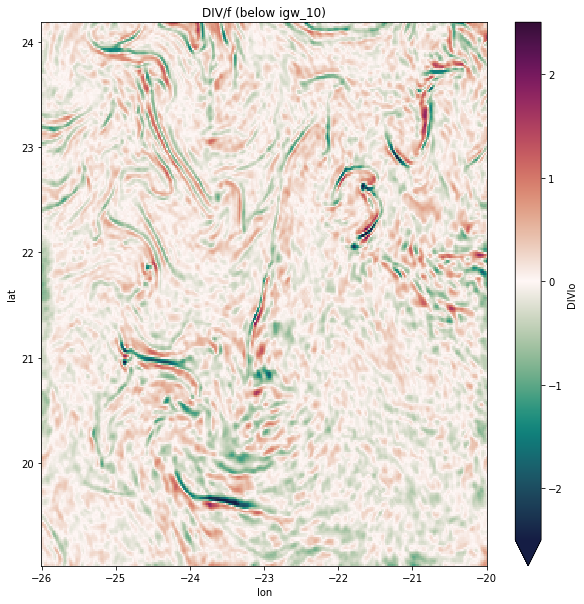

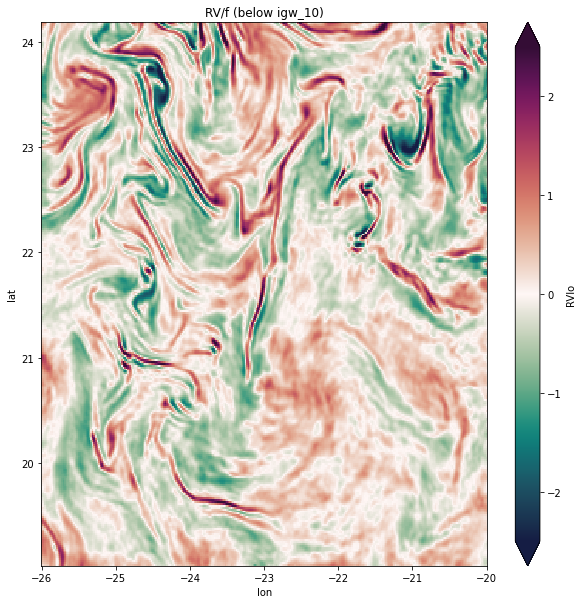

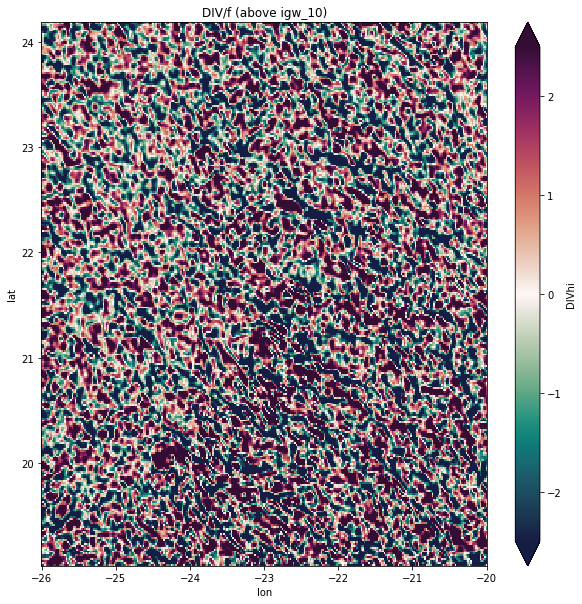

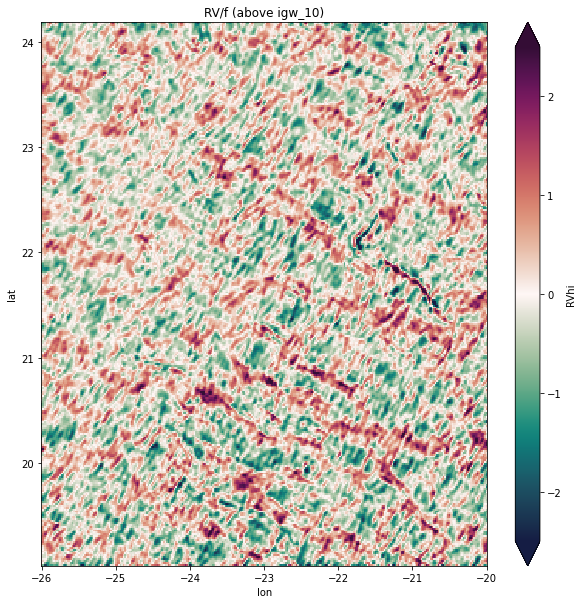

In [193]:
fig_kwargs={'x':'lon', 'y':'lat', 'cmap':'cmo.curl', 'norm':TwoSlopeNorm(vcenter=0.0), 'vmin':-2.5, 'vmax':2.5}

plt.figure(figsize=(10,10))
ds.DIVlo.isel(t=105).plot.pcolormesh(**fig_kwargs)
plt.title('DIV/f (below igw_10)')
plt.show()

plt.figure(figsize=(10,10))
ds.RVlo.isel(t=105).plot.pcolormesh(**fig_kwargs)
plt.title('RV/f (below igw_10)')
plt.show()

plt.figure(figsize=(10,10))
ds.DIVhi.isel(t=105).plot.pcolormesh(**fig_kwargs)
plt.title('DIV/f (above igw_10)')
plt.show()

plt.figure(figsize=(10,10))
ds.RVhi.isel(t=105).plot.pcolormesh(**fig_kwargs)
plt.title('RV/f (above igw_10)')
plt.show()

In [20]:
tslice = slice(10,-10)
print(tslice)

slice(10, -10, None)


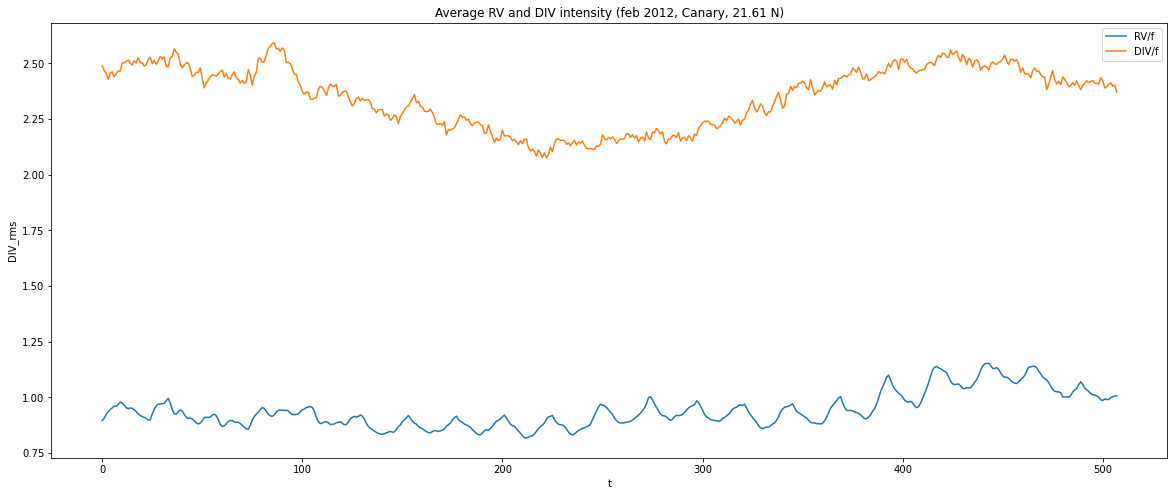

In [21]:
plt.figure(figsize=(20,8))
ds.RV_rms.isel(t=tslice).plot(label="RV/f")
ds.DIV_rms.isel(t=tslice).plot(label="DIV/f")
plt.legend()
plt.title("Average RV and DIV intensity (feb 2012, Canary, {:0.2f} N)".format(lat_deg))
plt.show()

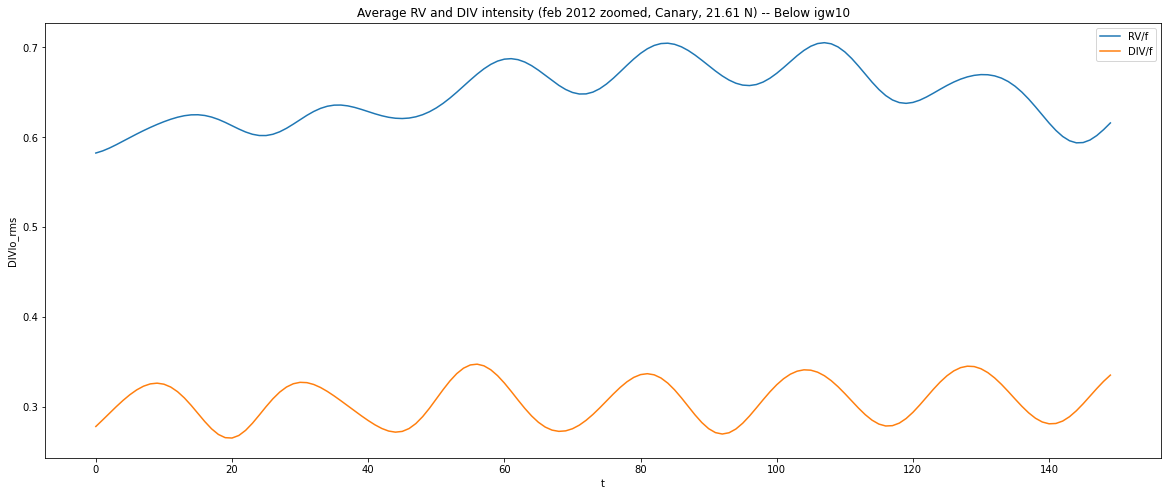

In [22]:
plt.figure(figsize=(20,8))
ds.RVlo_rms.isel(t=slice(200,350)).plot(label="RV/f")
ds.DIVlo_rms.isel(t=slice(200,350)).plot(label="DIV/f")
plt.legend()
plt.title("Average RV and DIV intensity (feb 2012 zoomed, Canary, {:0.2f} N) -- Below igw10".format(lat_deg))
plt.show()

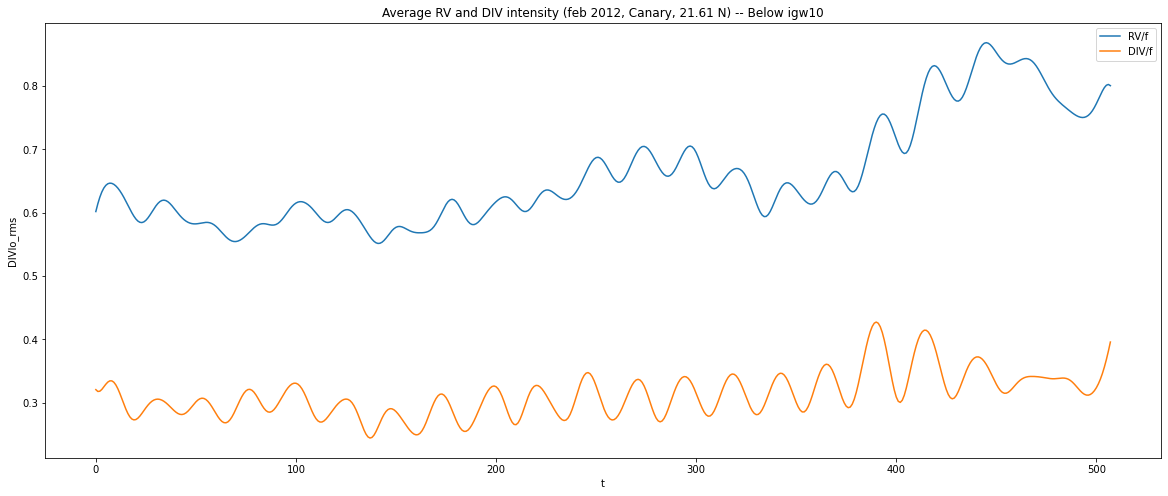

In [23]:
plt.figure(figsize=(20,8))
ds.RVlo_rms.isel(t=tslice).plot(label="RV/f")
ds.DIVlo_rms.isel(t=tslice).plot(label="DIV/f")
plt.legend()
plt.title("Average RV and DIV intensity (feb 2012, Canary, {:0.2f} N) -- Below igw10".format(lat_deg))
plt.show()

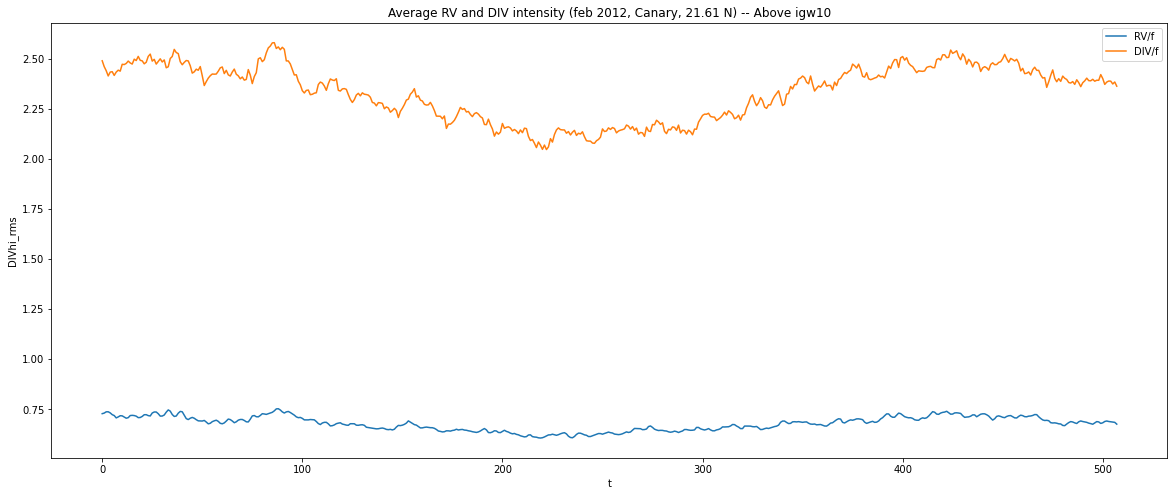

In [24]:
plt.figure(figsize=(20,8))
ds.RVhi_rms.isel(t=tslice).plot(label="RV/f")
ds.DIVhi_rms.isel(t=tslice).plot(label="DIV/f")
plt.legend()
plt.title("Average RV and DIV intensity (feb 2012, Canary, {:0.2f} N) -- Above igw10".format(lat_deg))
plt.show()

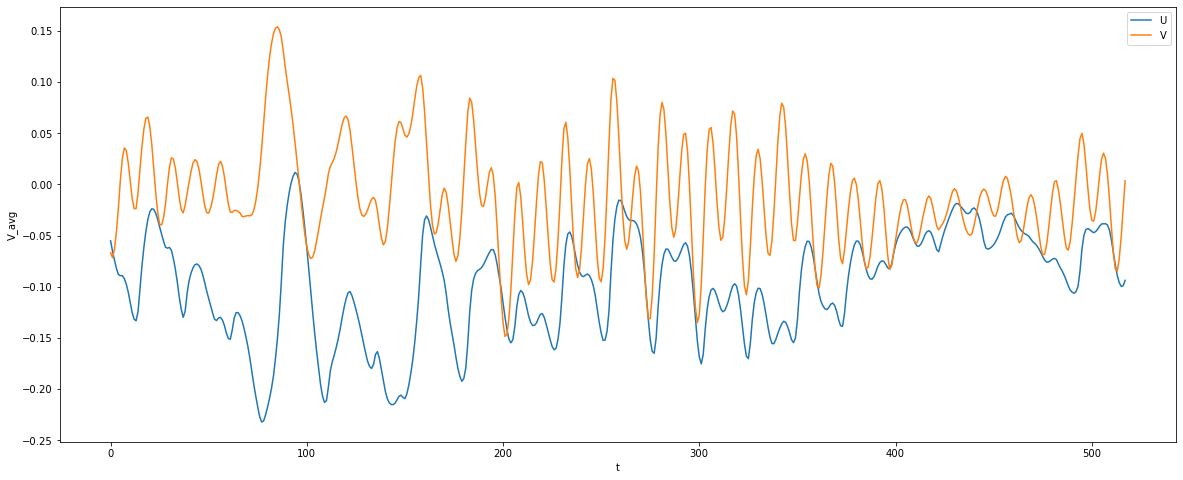

In [167]:
plt.figure(figsize=(20,8))
ds.U_avg.isel(t=tslice).plot(label="U")
ds.V_avg.isel(t=tslice).plot(label="V")
plt.legend()
plt.show()

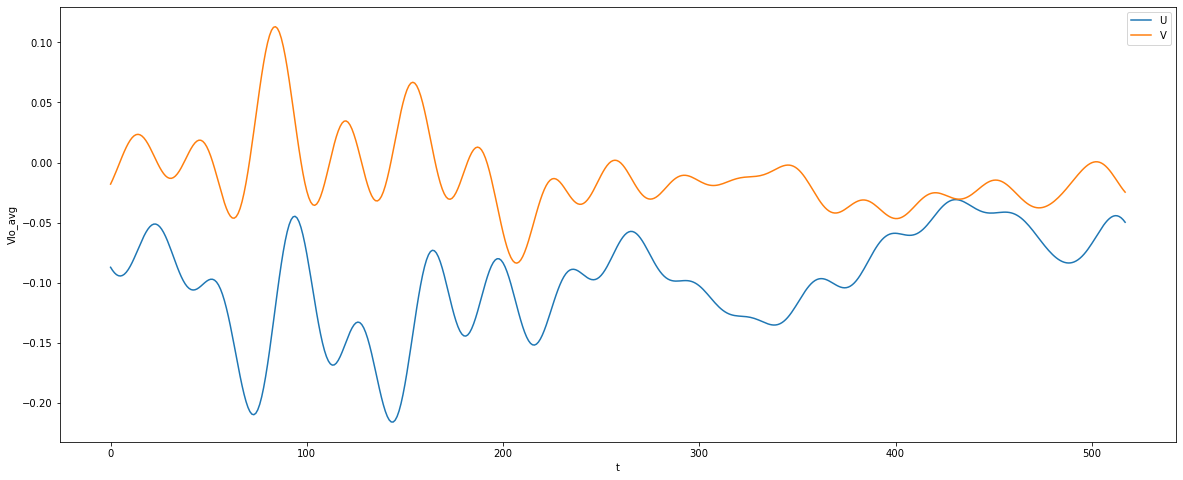

In [168]:
plt.figure(figsize=(20,8))
ds.Ulo_avg.sel(t=tslice).plot(label="U")
ds.Vlo_avg.sel(t=tslice).plot(label="V")
plt.legend()
plt.show()

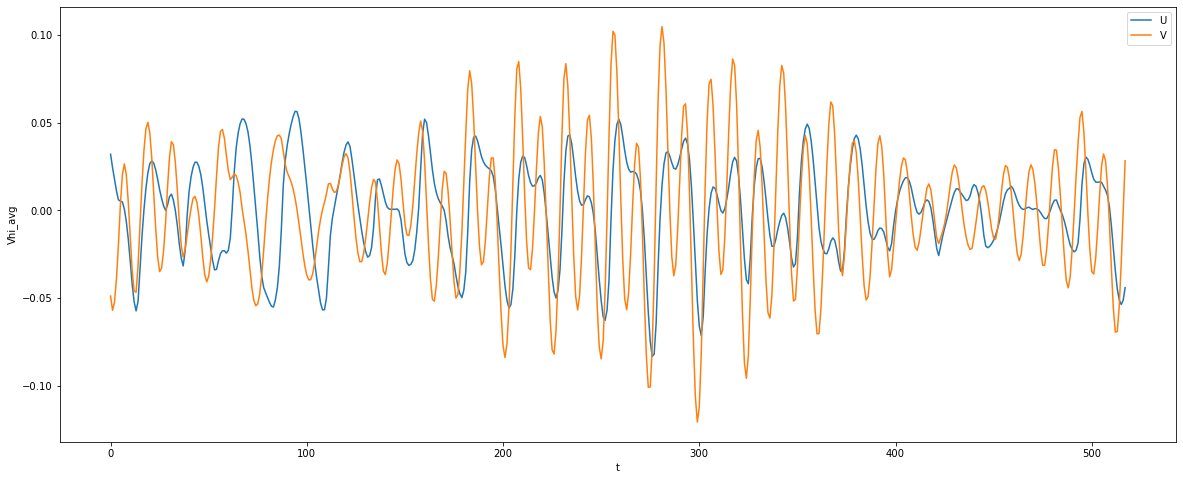

In [169]:
plt.figure(figsize=(20,8))
ds.Uhi_avg.isel(t=tslice).plot(label="U")
ds.Vhi_avg.isel(t=tslice).plot(label="V")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
ds.U_rms.isel(t=tslice).plot(label="U")
ds.V_rms.isel(t=tslice).plot(label="V")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
ds.Ulo_rms.sel(t=tslice).plot(label="U")
ds.Vlo_rms.sel(t=tslice).plot(label="V")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
ds.Uhi_rms.isel(t=tslice).plot(label="U")
ds.Vhi_rms.isel(t=tslice).plot(label="V")
plt.legend()
plt.show()